In [1]:
import numpy as np

import random
import h5py
from nn_util import *
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as K
from keras.initializers import *
import tensorflow

import os
import random
import time
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['font.family'] = "serif"
matplotlib.rcParams['font.serif'] = "Symbola"
matplotlib.rcParams['font.size'] = 12
import glob

import operator
import math
import re

# for reproducibility
np.random.seed(1337) 
random.seed(1337)

from keras.activations import softmax

# increase recursion limit for adaptive VQ
import sys
sys.setrecursionlimit(40000)

np.set_printoptions(formatter={'float_kind':'{:4f}'.format})

Using TensorFlow backend.


In [2]:
# control amount of GPU memory used
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
set_session(tf.Session(config=config))

In [3]:
import consts
consts.NBINS = 16
consts.BINS_INIT = np.linspace(-1.0, 1.0, consts.NBINS)
consts.QUANT_BINS = K.variable(consts.BINS_INIT, name = 'QUANT_BINS')
consts.QUANTIZATION_ON = K.variable(True, name = 'QUANTIZATION_ON')

In [4]:
# external custom code I wrote
from load_data import *
from windowing import *
from pesq import *
from consts import *
from nn_blocks import *
from perceptual_loss import *
from evaluation import *

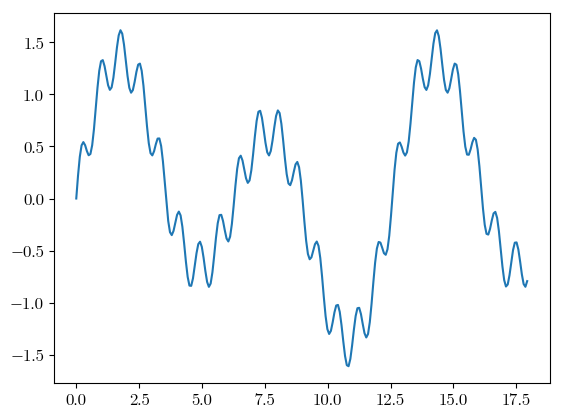

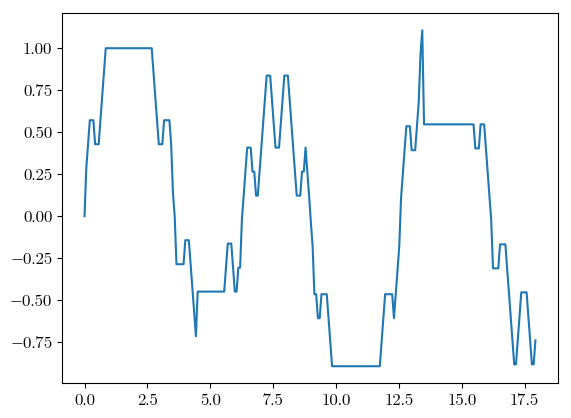

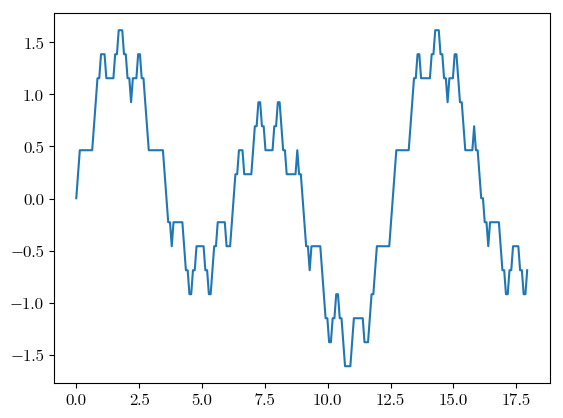

In [5]:
def find_nearest(array, value):
    idx = (np.abs(array - value)).argmin()
    return array[idx]

x = np.arange(0.0, 18.0, 18.0 / 256)
y = np.sin(x) + 0.5 * np.sin(x * 0.5) + 0.25 * np.sin(x * 8)

delta_codebook = np.linspace(-1.0, 1.0, 15)
uniform_codebook = np.linspace(np.min(y), np.max(y), 15)

# ----------------------------------------
# delta quantized
# ----------------------------------------

delta_step = 64

curr = 0.0
slope = 0.0
delta = np.zeros_like(y)
for i in xrange(0, np.size(delta), delta_step):
    lin = np.linspace(0.0, 1.0, delta_step)
    lin = (1 - np.cos(lin * 3.14159)) / 2.0
    lin = curr * (1.0 - lin) + (curr + slope) * lin
    
    d = y[i:i+delta_step] - curr
    
    quantized_d = np.zeros_like(d)
    for j in xrange(0, np.size(d)):
        quantized_d[j] = find_nearest(delta_codebook, d[j])
    
    delta[i:i+delta_step] = quantized_d
    slope = np.mean(quantized_d)
    curr += slope

print ""

curr = 0.0
recovered = np.zeros_like(y)
for i in xrange(0, np.size(recovered), delta_step):
    lin = np.linspace(0.0, 1.0, delta_step)
    lin = (1 - np.cos(lin * 3.14159)) / 2.0
    lin = curr * (1.0 - lin) + (curr + slope) * lin
    
    quantized_d = delta[i:i+delta_step]
    recovered[i:i+delta_step] = quantized_d + curr
    
    slope = np.mean(quantized_d)
    curr += slope

# ----------------------------------------
# regular uniform quantization
# ----------------------------------------
uquant = np.copy(y)
for i in xrange(0, np.size(uquant)):
    uquant[i] = find_nearest(uniform_codebook, uquant[i])

plt.plot(x, y)
plt.show()

plt.plot(x, recovered)
plt.show()

plt.plot(x, uquant)
plt.show()

In [6]:
def random_orthogonal_matrix(shape):
    num_rows = 1
    for dim in shape[:-1]:
        num_rows *= dim
    num_cols = shape[-1]
    flat_shape = (num_rows, num_cols)
    a = np.random.normal(0.0, 1.0, flat_shape)
    
    u, _, v = np.linalg.svd(a, full_matrices=False)
    q = u if u.shape == flat_shape else v
    
    q = q.reshape(shape)
    return K.variable(q)

In [7]:
ADAPT_STEP = 128
PRED_FILT_LENGTH = 15
PRED_CHANS = 8

NUM_PRED_CONVS = 5
PRED_FILTERS = []
PRED_BIASES = []
for i in xrange(0, NUM_PRED_CONVS):
    if (i == 0):
        filter_shape = (PRED_FILT_LENGTH, 1, PRED_CHANS)
        bias_shape = (1, 1, PRED_CHANS)
    elif (i == NUM_PRED_CONVS - 1):
        filter_shape = (PRED_FILT_LENGTH, PRED_CHANS, 1)
        bias_shape = (1, 1, 1)
    else:
        filter_shape = (PRED_FILT_LENGTH, PRED_CHANS, PRED_CHANS)
        bias_shape = (1, 1, PRED_CHANS)
    
    filter_init = random_orthogonal_matrix(filter_shape)
    PRED_FILTERS.append(K.variable(filter_init))
    PRED_BIASES.append(K.variable(np.zeros(bias_shape)))
    
print [K.int_shape(x) for x in PRED_FILTERS]

[(15, 1, 8), (15, 8, 8), (15, 8, 8), (15, 8, 8), (15, 8, 1)]


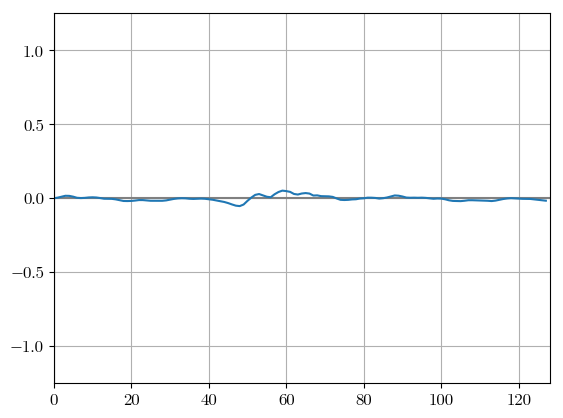

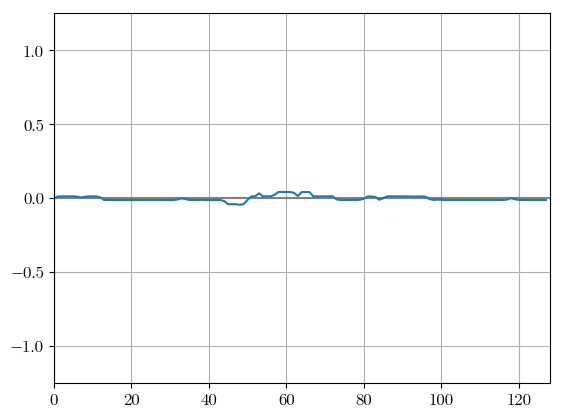

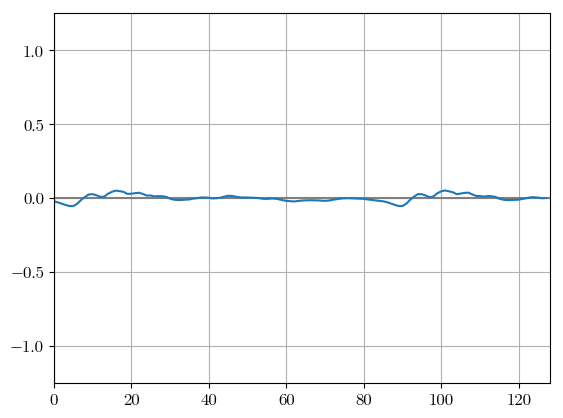

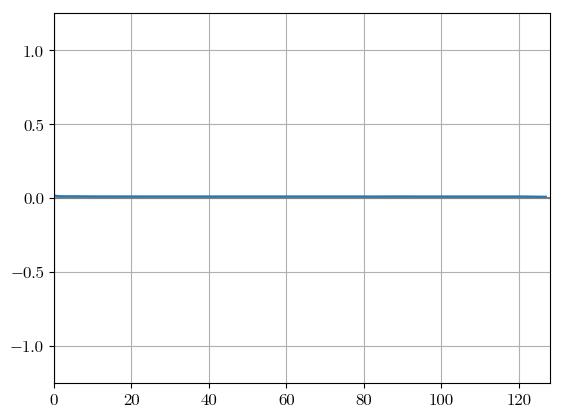

In [36]:
idx = 23
x = K.expand_dims(X_train[idx][:ADAPT_STEP, 0], 0)

curr_pred = tf.zeros([1, ADAPT_STEP])

curr_bins = K.expand_dims(QUANT_BINS, 0)

delta = x - curr_pred       
d_r = K.expand_dims(delta, -1)

c_r = K.expand_dims(curr_bins, -2)

dist = K.abs(d_r - c_r)
quant = softmax(500.0 * -dist)

d = K.batch_dot(quant, K.expand_dims(curr_bins, -1))
recons = curr_pred + K.squeeze(d, -1)

# new window is predicted by convolving reconstructed one
new_pred = K.expand_dims(recons, -1)
for i in xrange(0, NUM_PRED_CONVS):
    new_pred = K.conv1d(new_pred, PRED_FILTERS[i], padding = 'same',
                        data_format = 'channels_last')
    new_pred = new_pred + PRED_BIASES[i]
    new_pred = K.relu(new_pred, 0.3)
new_pred = K.squeeze(new_pred, -1)

predicted_window = K.eval(new_pred)[0]
actual_window = X_train[idx][ADAPT_STEP:(ADAPT_STEP*2), 0]

fancy_plot(K.eval(x)[0])
fancy_plot(K.eval(recons)[0])
fancy_plot(actual_window)
fancy_plot(predicted_window)

In [8]:
# quantization: takes in    [BATCH x WINDOW_SIZE]
#               and returns [BATCH x WINDOW_SIZE x NBINS]
# where the last dimension is a one-hot vector of bins
#
# [bins initialization is in consts.py]
class DeltaQuantization(Layer):
    def build(self, input_shape):
        self.SOFTMAX_TEMP = K.variable(500.0, name = 'softmax_temp')
        self.trainable_weights = [QUANT_BINS] + \
                                  PRED_FILTERS + PRED_BIASES + \
                                 [self.SOFTMAX_TEMP]
        super(DeltaQuantization, self).build(input_shape)
    
    # x is a vector: [BATCH_SIZE x ADAPT_STEP]
    # curr_pred is a vector: [BATCH_SIZE x ADAPT_STEP]
    # curr_bins is a vector: [BATCH_SIZE x NBINS]
    def step(self, x, curr_pred, curr_bins):
        # delta is: difference from what's in current window
        #           and predicted window
        #               [BATCH_SIZE x ADAPT_STEP]
        delta = x - curr_pred
        
        # d_r becomes: [BATCH_SIZE x ADAPT_STEP x 1]
        d_r = K.expand_dims(delta, -1)

        # c_r becomes: [BATCH_SIZE x 1 x NBINS]
        c_r = K.expand_dims(curr_bins, -2)

        # get L1 distance from each element to each of the bins
        # dist is: [BATCH_SIZE x ADAPT_STEP x NBINS]
        dist = K.abs(d_r - c_r)

        # turn into softmax probabilities, which we return
        # quant is: [BATCH_SIZE x ADAPT_STEP x NBINS]
        quant = softmax(self.SOFTMAX_TEMP * -dist)
        
        # get reconstructed window from what we just quantized
        # d is: [BATCH_SIZE x ADAPT_STEP x 1]
        d = K.batch_dot(quant, K.expand_dims(curr_bins, -1))
        recons = curr_pred + K.squeeze(d, -1)
        
        # new window is predicted by convolving reconstructed one
        new_pred = K.expand_dims(recons, -1)
        for i in xrange(0, NUM_PRED_CONVS):
            new_pred = K.conv1d(new_pred, PRED_FILTERS[i], padding = 'same',
                                data_format = 'channels_last')
            new_pred = new_pred + PRED_BIASES[i]
            new_pred = K.relu(new_pred, 0.3)
        new_pred = K.squeeze(new_pred, -1)
        
        return quant, new_pred, curr_bins
    
    def call(self, x, mask = None):
        # construct a symbolic tensor [BATCH_SIZE x 1] we can use to tile things
        tile_amt = [tf.shape(x)[0]]
        tile_amt = tf.concat([tile_amt, tf.ones((1,), dtype = tf.int32)], axis = 0)
        
        # prediction window always starts at zero
        curr_pred = tf.zeros([tf.shape(x)[0], ADAPT_STEP])
        
        # bins always starts at QUANT_BINS
        curr_bins = K.expand_dims(QUANT_BINS, 0)
        curr_bins = tf.tile(curr_bins, tile_amt)
        
        # out becomes: list of length [WINDOW_SIZE / ADAPT_STEP]
        #                  of BATCH_SIZE x ADAPT_STEP x NBINS length testors
        mod_x = K.reshape(x, (-1, x.shape[1] / ADAPT_STEP, ADAPT_STEP))
        mod_x = tf.unstack(tf.transpose(mod_x, [1, 0, 2]))
        out = []
        for i in mod_x:
            w, curr_pred, curr_bins = self.step(i, curr_pred, curr_bins)
            out.append(w)
        
        # we finagle this into: [BATCH_SIZE x WINDOW_SIZE x NBINS]
        enc = tf.transpose(tf.stack(out), [1, 0, 2, 3])
        enc = K.reshape(enc, (-1, enc.shape[1] * enc.shape[2], NBINS))
        return enc
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1], NBINS)

In [9]:
# dequantization: takes in    [BATCH x WINDOW_SIZE x NBINS]
#                 and returns [BATCH x WINDOW_SIZE]
class DeltaDequantization(Layer):
    # x is a vector of size [BATCH_SIZE x ADAPT_STEP x NBINS] -- 1 time step
    # curr_pred is a vector: [BATCH_SIZE x ADAPT_STEP]
    # curr_bins is a vector: [BATCH_SIZE x NBINS]
    def step(self, x, curr_pred, curr_bins):
        quant = x
        
        # reconstructed window
        # d is: [BATCH_SIZE x ADAPT_STEP x 1]
        d = K.batch_dot(quant, K.expand_dims(curr_bins, -1))
        recons = curr_pred + K.squeeze(d, -1)
        
        # new window is predicted by convolving reconstructed one
        new_pred = K.expand_dims(recons, -1)
        for i in xrange(0, NUM_PRED_CONVS):
            new_pred = K.conv1d(new_pred, PRED_FILTERS[i], padding = 'same',
                                data_format = 'channels_last')
            new_pred = new_pred + PRED_BIASES[i]
            new_pred = K.relu(new_pred, 0.3)
        new_pred = K.squeeze(new_pred, -1)
        
        return recons, new_pred, curr_bins
        
    def call(self, x, mask=None):
        # construct a symbolic tensor [BATCH_SIZE x 1] we can use to tile things
        tile_amt = [tf.shape(x)[0]]
        tile_amt = tf.concat([tile_amt, tf.ones((1,), dtype = tf.int32)], axis = 0)
        
        # prediction window always starts at zero
        curr_pred = tf.zeros([tf.shape(x)[0], ADAPT_STEP])
        
        # bins always starts at QUANT_BINS
        curr_bins = K.expand_dims(QUANT_BINS, 0)
        curr_bins = tf.tile(curr_bins, tile_amt)
        
        mod_x = K.reshape(x, (-1, x.shape[1] / ADAPT_STEP, ADAPT_STEP, x.shape[2]))
        mod_x = tf.unstack(tf.transpose(mod_x, [1, 0, 2, 3]))
        out = []
        for i in mod_x:
            w, curr_pred, curr_bins = self.step(i, curr_pred, curr_bins)
            out.append(w)
            
        dec = tf.transpose(tf.stack(out), [1, 0, 2])
        dec = K.reshape(dec, (-1, dec.shape[1] * ADAPT_STEP))
        return dec
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1])

In [10]:
[train_paths, val_paths, test_paths], \
[train_waveforms, val_waveforms, test_waveforms], \
[train_procwave, val_procwave, test_procwave], \
[train_wparams, val_wparams, test_wparams], \
[train_windows, val_windows, test_windows] = load_data(TRAIN_SIZE, VAL_SIZE, TEST_SIZE)

In [11]:
# flatten all of the train windows into vectors
train_processed = np.array([i for z in train_windows for i in z])
train_processed = np.reshape(train_processed, (train_processed.shape[0], WINDOW_SIZE, 1))

# randomly shuffle data, if we want to
if (RANDOM_SHUFFLE):
    np.random.seed(1337)
    train_processed = np.random.permutation(train_processed)
    
print train_processed.shape
print np.mean(train_processed, axis=None)
print np.std(train_processed, axis=None)
print np.min(train_processed, axis = None)
print np.max(train_processed, axis = None)

X_train = np.copy(train_processed)

(101750, 512, 1)
3.81413e-06
0.103483
-1.0
1.0


# Backward Adaptive Quantization

In [12]:
# we can compute the entropy of a batch directly
def code_entropy(placeholder, code):
    all_onehots = K.reshape(code, (-1, NBINS))
    onehot_hist = K.sum(all_onehots, axis = 0)
    onehot_hist /= K.sum(onehot_hist)

    entropy = -K.sum(onehot_hist * K.log(onehot_hist + K.epsilon()) / K.log(2.0))
    return entropy

def code_sparsity(placeholder, code):
    sparsity = K.mean(K.sum(K.sqrt(code + K.epsilon()), axis = -1), axis = -1) - 1.0
    return sparsity

In [13]:
input_dim = (WINDOW_SIZE, 1)

enc_input = Input(shape = input_dim)
enc = Reshape((WINDOW_SIZE, 1))(enc_input)
#enc = Conv1D(1, 15, padding = 'same',
#             kernel_initializer = 'he_uniform',
#             activation = 'linear')(enc)
enc = DeltaQuantization()(enc)
enc = Model(inputs = enc_input, outputs = enc)

dec_input = Input(shape = (WINDOW_SIZE, NBINS))
dec = DeltaDequantization()(dec_input)
dec = Reshape((WINDOW_SIZE, 1))(dec)
#dec = Conv1D(1, 15, padding = 'same',
#             kernel_initializer = 'he_uniform',
#             activation = 'linear')(dec)
dec = Model(inputs = dec_input, outputs = dec)

In [14]:
n_recons = 2
n_code = 1
losses = [rmse, perceptual_distance, code_sparsity]
weights = [30.0, 1.0, 5.0]

model_input = Input(shape = input_dim)
model_embedding = enc(model_input)
model_reconstructed = dec(model_embedding)
model = Model(inputs = [model_input], outputs = [model_reconstructed] * n_recons + \
                                                [model_embedding] * n_code)

model.compile(loss = losses,
              loss_weights = weights,
              optimizer = Adam())
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 512, 1)            0         
_________________________________________________________________
model_1 (Model)              (None, 512, 16)           3170.0    
_________________________________________________________________
model_2 (Model)              (None, 512, 1)            0         
Total params: 3,170
Trainable params: 3,170
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python2.7/dist-packages/keras/engine/topology.py:1511: UserWarning: The list of outputs passed to the model is redundant. All outputs should only appear once. Found: [<tf.Tensor 'model_2/reshape_2/Reshape:0' shape=(?, 512, 1) dtype=float32>, <tf.Tensor 'model_2/reshape_2/Reshape:0' shape=(?, 512, 1) dtype=float32>, <tf.Tensor 'model_1/delta_quantization_1/Reshape_1:0' shape=(?, 512, 16) dtype=float32>]
  ' Found: ' + str(self.outputs))


In [15]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

In [16]:
def fancy_plot(x, y = None, yl = (-1.25, 1.25), dots = False, axes = True):
    if (axes):
        plt.axhline(0, color = 'gray')
        plt.axvline(0, color = 'gray')

    if (dots):
        sc = '.'
        ms = 3
    else:
        sc = '-'
        ms = 2
    
    if (y is not None):
        plt.plot(x, y, sc, ms = ms)
    else:
        plt.plot(x, sc, ms = ms)
    plt.grid()
    
    if (yl is not None):
        plt.ylim(yl[0], yl[1])
        
    if (y is None):
        plt.xlim(0, len(x))
        
    plt.show()

## Before training

In [17]:
test_model_on_wav("./SA1.wav", "SA1_quant_before", model)

MSE:         44184.4
Avg err:     190.482
PESQ:        1.17391586304


[44184.391, 190.48218, 1.1739158630371094]

Original


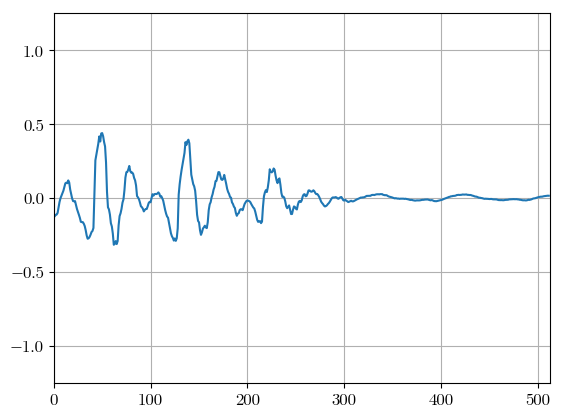

Reconstruction


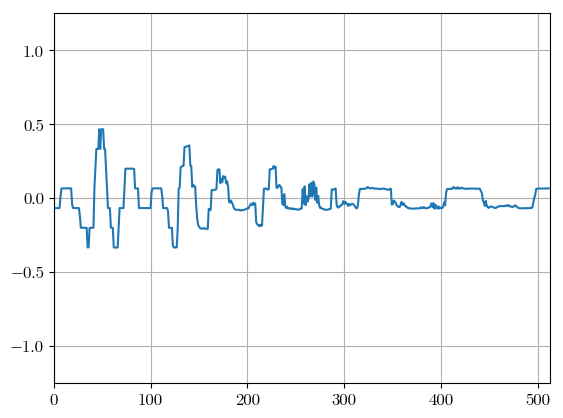

In [18]:
idx = 45

orig = X_train[idx].flatten()
recn = model.predict(X_train[idx:idx+1], verbose = 0)[0].flatten()

print "Original"
fancy_plot(orig, axes = False)

print "Reconstruction"
fancy_plot(recn, axes = False)

## After training

In [19]:
y_train = [X_train] * n_recons + \
          [np.zeros((X_train.shape[0], 1, 1))] * n_code      

model.fit(X_train, y_train, verbose = 1, epochs = 20, batch_size = 128)

Epoch 1/20
101750/101750 [==============================] - 10s - loss: 2.1784 - model_2_loss_1: 0.0117 - model_2_loss_2: 1.4941 - model_1_loss: 0.0666    
Epoch 2/20
101750/101750 [==============================] - 9s - loss: 1.9196 - model_2_loss_1: 0.0078 - model_2_loss_2: 1.2481 - model_1_loss: 0.0873     
Epoch 3/20
101750/101750 [==============================] - 9s - loss: 1.9098 - model_2_loss_1: 0.0079 - model_2_loss_2: 1.2220 - model_1_loss: 0.0903     
Epoch 4/20
101750/101750 [==============================] - 9s - loss: 1.9091 - model_2_loss_1: 0.0079 - model_2_loss_2: 1.2255 - model_1_loss: 0.0895     
Epoch 5/20
101750/101750 [==============================] - 9s - loss: 1.9074 - model_2_loss_1: 0.0079 - model_2_loss_2: 1.2223 - model_1_loss: 0.0898     
Epoch 6/20
101750/101750 [==============================] - 9s - loss: 1.9084 - model_2_loss_1: 0.0078 - model_2_loss_2: 1.2260 - model_1_loss: 0.0894     
Epoch 7/20
101750/101750 [==============================] - 9s -

KeyboardInterrupt: 

In [20]:
test_model_on_wav("./SA1.wav", "SA1_quant_after", model, argmax = False)

MSE:         6043.59
Avg err:     31.8934
PESQ:        2.02022337914


[6043.5942, 31.893404, 2.020223379135132]

In [21]:
all_embed = enc.predict(X_train[:10000], batch_size = 128, verbose = 0)

probs = np.reshape(all_embed, (all_embed.shape[0] * all_embed.shape[1], NBINS))
hist = np.sum(probs, axis = 0)
hist /= np.sum(hist)

entropy = 0
for i in hist:
    if (i < 1e-4): continue
    entropy += i * math.log(i, 2)
entropy = -entropy
print "Entropy of distribution:", entropy

Entropy of distribution: 2.95884768686


Original


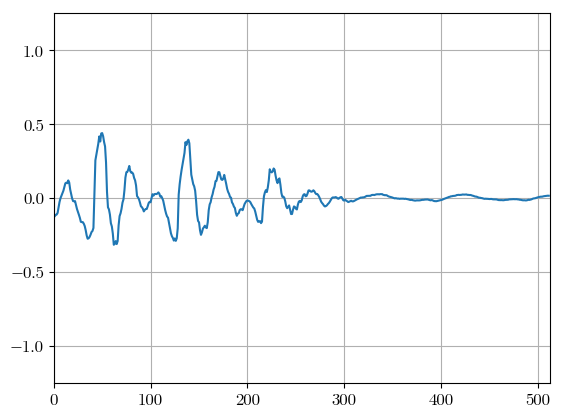

Reconstruction


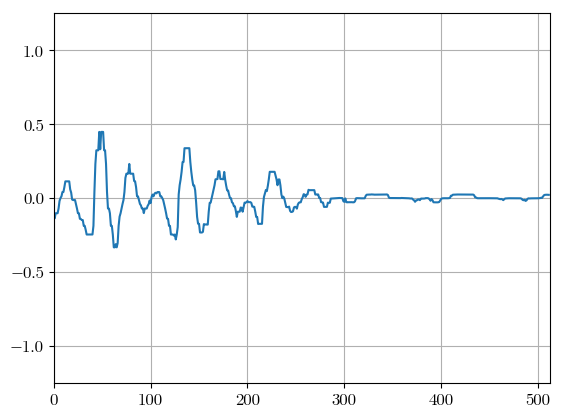

In [22]:
idx = 45

orig = X_train[idx].flatten()
recn = model.predict(X_train[idx:idx+1], verbose = 0)[0].flatten()

print "Original"
fancy_plot(orig, axes = False)

print "Reconstruction"
fancy_plot(recn, axes = False)